# phoBERT 
*Time for run all (GPU) : ~ 8 hours*

<a name="setup-general"></a>
## 1.&nbsp;General Settings
 Install some necessary libraries and download processed data for model training and evaluation

In [ ]:
!git clone https://github.com/helloitsurdvq/StockReview.IntroAI.20222.git

In [ ]:
%ls StockReview.IntroAI.20222/source/data/

In [ ]:
%cd StockReview.IntroAI.20222/

In [ ]:
%cd source/

In [2]:
nepochs = 15
batchsize= 8  #8, 16, 32, 64, 128
learning_rate= 5e-5 # 3e-4, 1e-4, 5e-5, 3e-5 
warmup = 0
seed = 0

log_name = '{}_nepochs_{}_batchsize_{}_learning_rate_{}'.format(seed, nepochs, batchsize, learning_rate, warmup)
output = './checkpoints/' + log_name

## 2. Import Libraries

In [2]:
!pip install transformers
!pip install datasets

You should consider upgrading via the 'C:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [30]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import Trainer
from transformers import TrainingArguments
from datasets import load_metric
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

In [4]:
#Load pre-trained phoBERT for finetuning on our dataset
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

## 3. Data Preparation
In this section, we will load the dataset from the converted data and prepare for model training

In [5]:
def tokenize_function(examples):
    tokenized_examples = tokenizer(examples['text'], padding="max_length", truncation=True)
    
    # Convert label from string to integer
    tokenized_examples['label'] = [int(label_id) for label_id in examples['label_id']]
    
    return tokenized_examples

In [6]:
train_dataset = load_dataset("csv", data_files='data\\stock_train.csv', split='train')
dev_dataset = load_dataset("csv", data_files='data\\stock_train.csv', split="train")

Found cached dataset csv (C:/Users/DELL/.cache/huggingface/datasets/csv/default-bf36123f4e2f25d6/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
Found cached dataset csv (C:/Users/DELL/.cache/huggingface/datasets/csv/default-bf36123f4e2f25d6/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


In [7]:
train_dataset

Dataset({
    features: ['text', 'label', 'label_id'],
    num_rows: 1516
})

In [8]:
train_dataset = train_dataset.map(tokenize_function, batched=True).shuffle(seed=seed)
dev_dataset = dev_dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\DELL\.cache\huggingface\datasets\csv\default-bf36123f4e2f25d6\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-c65982c41f9cff96.arrow
Loading cached shuffled indices for dataset at C:\Users\DELL\.cache\huggingface\datasets\csv\default-bf36123f4e2f25d6\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-2984cd2fb4254c22.arrow
Loading cached processed dataset at C:\Users\DELL\.cache\huggingface\datasets\csv\default-bf36123f4e2f25d6\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-c65982c41f9cff96.arrow


## 4.Model training and Evaluation

In [44]:
!pip install --upgrade accelerate

^C


You should consider upgrading via the 'C:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\Scripts\python.exe -m pip install --upgrade pip' command.


### Basic settings

In [9]:
#Hyperparameters
training_args = TrainingArguments(
  output_dir="checkpoint",
  group_by_length=False,
  evaluation_strategy="steps",
  num_train_epochs=nepochs,
  per_device_train_batch_size=batchsize,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  dataloader_num_workers=3, #tune
  learning_rate=learning_rate, #tune
  save_total_limit=15, #tune
  eval_accumulation_steps=2000, #tune
  warmup_ratio=0.1,
  report_to='tensorboard'
)

In [10]:
metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, label_id = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=label_id, average='weighted')

C:\Users\DELL\AppData\Local\Temp\ipykernel_18752\1968234401.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


### Training

In [11]:
trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=dev_dataset, compute_metrics=compute_metrics
)

In [12]:
trainer.train()

c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 18%|█▊        | 500/2850 [1:16:05<5:03:36,  7.75s/it]

{'loss': 0.7218, 'learning_rate': 4.580896686159844e-05, 'epoch': 2.63}


                                                      
 18%|█▊        | 500/2850 [1:25:02<5:03:36,  7.75s/it]

{'eval_loss': 0.33370500802993774, 'eval_f1': 0.8959108867254427, 'eval_runtime': 536.6738, 'eval_samples_per_second': 2.825, 'eval_steps_per_second': 0.354, 'epoch': 2.63}


 35%|███▌      | 1000/2850 [2:30:58<3:54:44,  7.61s/it]  

{'loss': 0.2809, 'learning_rate': 3.606237816764133e-05, 'epoch': 5.26}


                                                       
 35%|███▌      | 1000/2850 [2:39:46<3:54:44,  7.61s/it]

{'eval_loss': 0.0715378150343895, 'eval_f1': 0.9808959387284439, 'eval_runtime': 528.3033, 'eval_samples_per_second': 2.87, 'eval_steps_per_second': 0.36, 'epoch': 5.26}


 53%|█████▎    | 1500/2850 [3:41:29<2:43:29,  7.27s/it]  

{'loss': 0.0831, 'learning_rate': 2.6315789473684212e-05, 'epoch': 7.89}


                                                       
 53%|█████▎    | 1500/2850 [3:49:50<2:43:29,  7.27s/it]

{'eval_loss': 0.03457590937614441, 'eval_f1': 0.9940629434797804, 'eval_runtime': 500.5094, 'eval_samples_per_second': 3.029, 'eval_steps_per_second': 0.38, 'epoch': 7.89}


 70%|███████   | 2000/2850 [5:21:12<1:42:42,  7.25s/it]   

{'loss': 0.0323, 'learning_rate': 1.6569200779727097e-05, 'epoch': 10.53}


                                                       
 70%|███████   | 2000/2850 [5:29:35<1:42:42,  7.25s/it]

{'eval_loss': 0.010497677139937878, 'eval_f1': 0.9980212737940849, 'eval_runtime': 502.34, 'eval_samples_per_second': 3.018, 'eval_steps_per_second': 0.378, 'epoch': 10.53}


 88%|████████▊ | 2500/2850 [6:32:29<43:54,  7.53s/it]    

{'loss': 0.0148, 'learning_rate': 6.82261208576998e-06, 'epoch': 13.16}


                                                     
 88%|████████▊ | 2500/2850 [6:41:16<43:54,  7.53s/it]

{'eval_loss': 0.004323609173297882, 'eval_f1': 0.9986807783469691, 'eval_runtime': 527.103, 'eval_samples_per_second': 2.876, 'eval_steps_per_second': 0.36, 'epoch': 13.16}


100%|██████████| 2850/2850 [7:25:36<00:00,  9.38s/it]    

{'train_runtime': 26736.2081, 'train_samples_per_second': 0.851, 'train_steps_per_second': 0.107, 'train_loss': 0.1995901364610906, 'epoch': 15.0}


TrainOutput(global_step=2850, training_loss=0.1995901364610906, metrics={'train_runtime': 26736.2081, 'train_samples_per_second': 0.851, 'train_steps_per_second': 0.107, 'train_loss': 0.1995901364610906, 'epoch': 15.0})

In [14]:
model.save_pretrained("output/trained_model")

In [15]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [16]:
device = 'cpu'

### Evaluation on test set

In [17]:
test_data = pd.read_csv('data/stock_test.csv')

predictions = []
labels = []

In [18]:
test_data

,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
1135,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
1136,báo cáo giải trình của SHS cho biết,neutral,2
1137,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1138,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [19]:
for i in tqdm(range(test_data.shape[0])):
    input_str = test_data['text'][i]

    input_values = tokenizer(input_str, return_tensors="pt", truncation=True, padding='max_length').input_ids.to(device)
    logits = model(input_values).logits

    prediction = np.argmax(logits.cpu().detach().numpy(), axis=-1)[0]

    labels.append(int(test_data['label_id'][i]))
    predictions.append(int(prediction))

100%|██████████| 1140/1140 [05:47<00:00,  3.28it/s]


              precision    recall  f1-score   support

    positive       0.89      0.65      0.75       373
    negative       0.92      0.72      0.81       341
     neutral       0.65      0.91      0.76       426

    accuracy                           0.77      1140
   macro avg       0.82      0.76      0.77      1140
weighted avg       0.81      0.77      0.77      1140



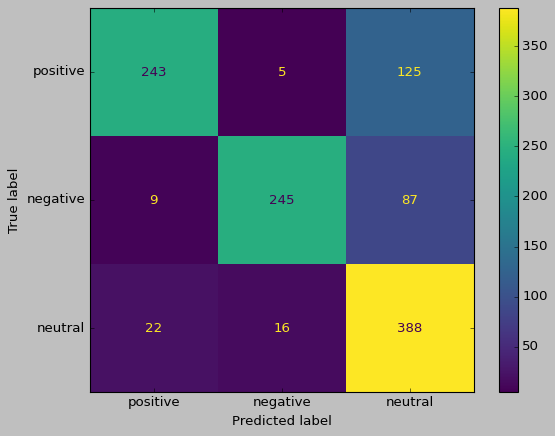

In [31]:
target_names = ['positive',
 'negative',
 'neutral']
print(classification_report(labels, predictions, target_names=target_names, digits=2))

cm = confusion_matrix(labels, predictions)
_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
_display.plot()
plt.show()